<a href="https://www.kaggle.com/code/superlaye/house-price-reg?scriptVersionId=157735935" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt 

import scipy.stats as st
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
pd.set_option('display.max_columns', 20)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler 

In [4]:
import xgboost as xgb

# 1 Load Dataset and EDA
Checking for missing values, identifying outliers, and exploring feature distributions 

- train data

In [5]:
df_train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
print("Full train dataset shape is {}".format(df_train.shape))
print(df_train.info())
print("The size of training examples ",df_train.shape)
print(df_train.describe())
ids_train=df_train.pop('Id')

Full train dataset shape is (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual  

In [6]:
df_test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
print("\nFull test dataset shape is {}".format(df_test.shape))
print(df_test.info())
print("The size of test examples ",df_test.shape)
print(df_test.describe())
ids_test=df_test.pop('Id' )


Full test dataset shape is (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual  

The dataset contain (1460+1459) entries with total 81 features (36 numerical+43 categorical+ID). Training dataset contaion y(SalePrice)

## 1.2 Data Exploration 
    -  check the target values  
    -  check features ( cat|num,dependencies|correlation|funtionality, missing values)

### 1.2.1 Target Values

Skewness :1.8828757597682129
kurtosis: 6.536281860064529


<Axes: >

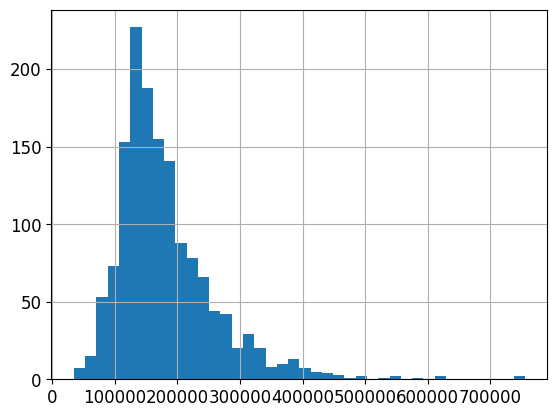

In [7]:
print(f"Skewness :{ df_train['SalePrice'].skew()}")
print(f"kurtosis: {df_train['SalePrice'].kurt()}")
df_train['SalePrice'].hist(bins=40)

- Outliers

Go through all varilables and find ['OverallQual','YearBuilt','TotalBsmtSF','GrLivArea'] are quiet important features. Hence the outliers of salePrice in terms of this 4 feature first 

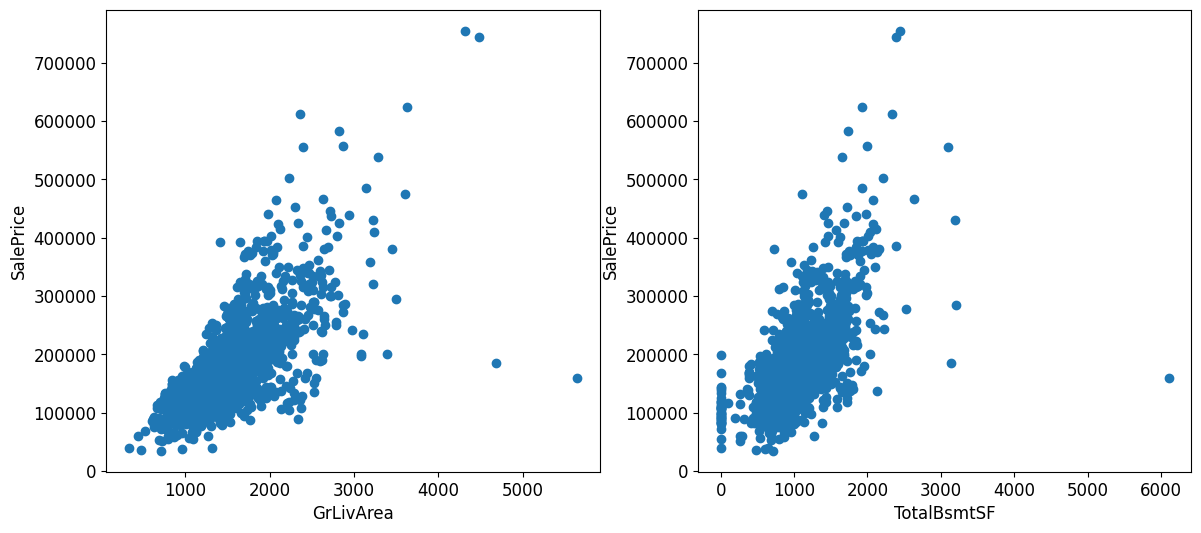

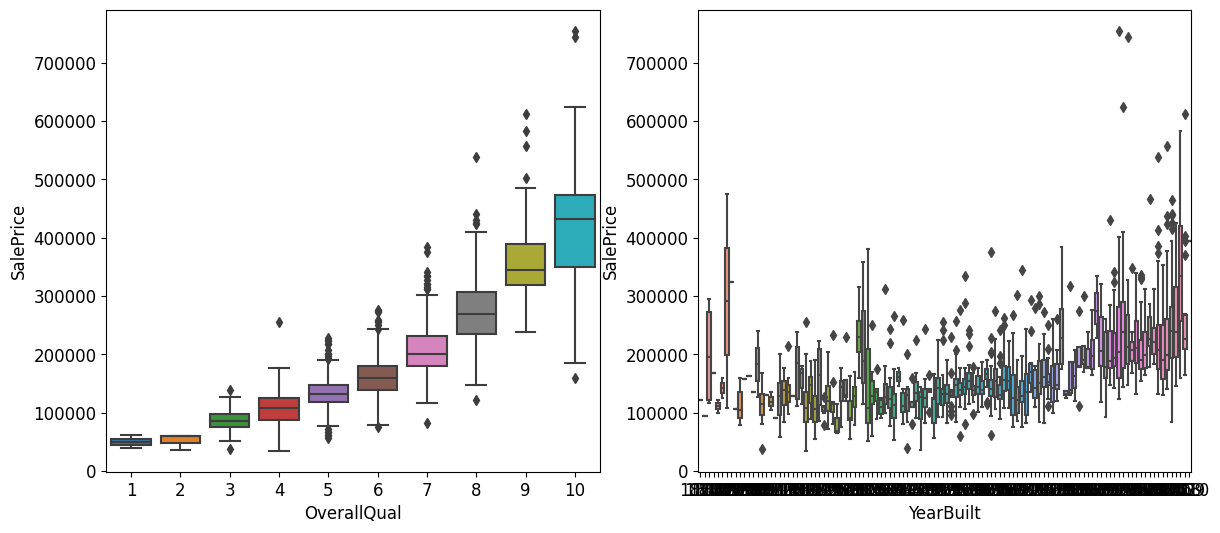

In [8]:
# Relationship with numerical features

imp_num_var='GrLivArea' 
fig,ax=plt.subplots(1,2,figsize=(14,6))
ax[0].scatter(df_train[imp_num_var],df_train['SalePrice'])
ax[0].set_ylabel('SalePrice');
ax[0].set_xlabel(imp_num_var);
imp_num_var='TotalBsmtSF'
ax[1].scatter(df_train[imp_num_var],df_train['SalePrice'])
ax[1].set_ylabel('SalePrice');
ax[1].set_xlabel(imp_num_var);
# Relationship with categorical features
imp_cat_var='OverallQual'
fig,ax2=plt.subplots(1,2,figsize=(14,6))
 
# print(impcat_y.head())
sns.boxplot(x=df_train[imp_cat_var],y=df_train['SalePrice'],ax=ax2[0])
ax2[0].set_ylabel('SalePrice');
ax2[0].set_xlabel(imp_cat_var);
imp_cat_var='YearBuilt'
 
sns.boxplot(x=df_train[imp_cat_var],y=df_train['SalePrice'],ax=ax2[1])
 
ax2[1].set_ylabel('SalePrice');
ax2[1].set_xlabel(imp_cat_var);

**[Comments]**
From the scattering plots( Bivariate analysis), we can see that 
- A) two values with bigger 'GrLivArea' seem strange and they are not following the crowd. [action: delete them]

In [9]:
print(df_train.shape)
df_train.drop([1298,523],inplace=True)
print(df_train.shape)
y_train_org=df_train[['SalePrice']]

(1460, 80)
(1458, 80)


### 1.2.2 Features

- check feature distributions
- check the null values for all features where (The test and the train set will be combined together for the convicence)

-  For some  features which intuitively strong depend on others
    -  BsmtQual|BsmtCon/TotalBsmtSF(Total square feet of basement area)
    -  PoolQC/PoolArea
    -  MasVnrType/MasVnrArea(Masonry veneer area in square feet)
    -  MiscVal =f  MiscFeature
    -  GarageQual|GarageType =f GarageArea
    -  GarageQual|GarageType =f GarageFinish(interior finish of the garage)
    -  TotalBsmtSF=BsmtFinSF1+BsmtFinSF2+BsmtUnfSF
    -  KitchenQual/Kitchen
    -  FireplaceQu|Fireplaces

**Categoricals**

In [10]:
cateogricals=df_train.select_dtypes(exclude=[np.number])
category_names=cateogricals.columns.tolist()
print("The number of categorical feature is ", cateogricals.shape[1])
print( cateogricals.dtypes[~cateogricals.dtypes.isin([np.number])]  )
print(cateogricals.describe())

The number of categorical feature is  43
MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object

**[Note]**: for categorical featues we can 
- (1) check distribution of SalePrice for each varilable and enumerate them
- (2) creat dummy variables for each category

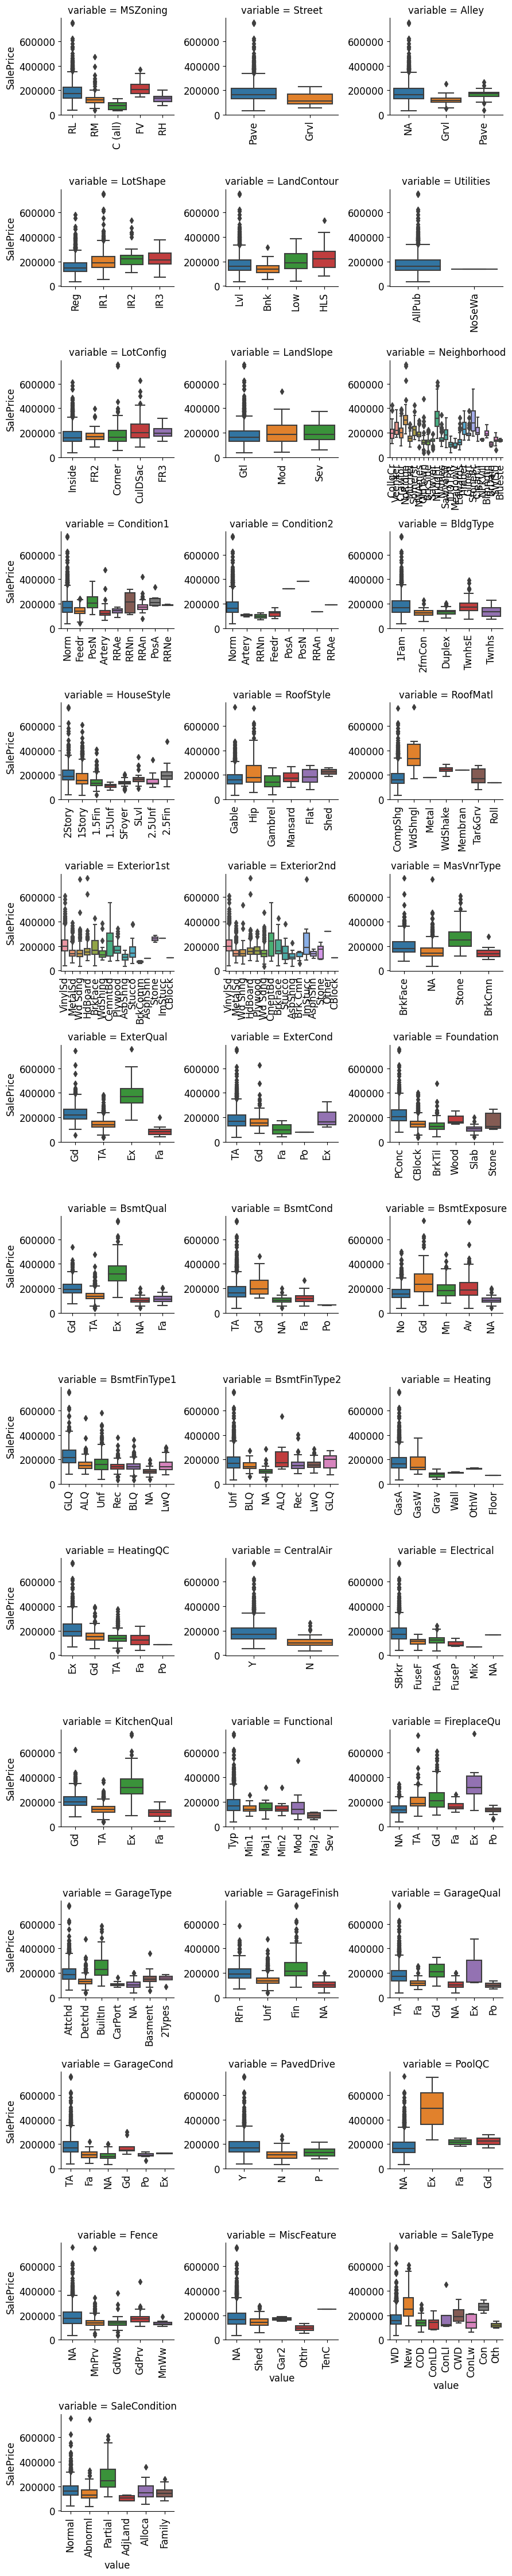

In [11]:
#(1)
def cateogryType(category_names,df):
    for obj in category_names:
        # 1st convert it to the categorical data type
        df[obj]=df[obj].astype('category')
        # if exiting none values
        if df[obj].isnull().any():
            # new new categiry as NA
            df[obj]=df[obj].cat.add_categories(['NA'])
            df[obj]=df[obj].fillna('NA')

cateogryType(category_names,df_train)
 
        
def boxplot(x,y, **kws):
    sns.boxplot(x=x,y=y)
    plt.xticks(rotation=90)
f=pd.melt(frame=df_train,id_vars=['SalePrice'],value_vars=category_names)
g=sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False)
g=g.map(boxplot,'value','SalePrice')


**[Comments]**: some feaureas exhibit more diverse than others  

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600')])

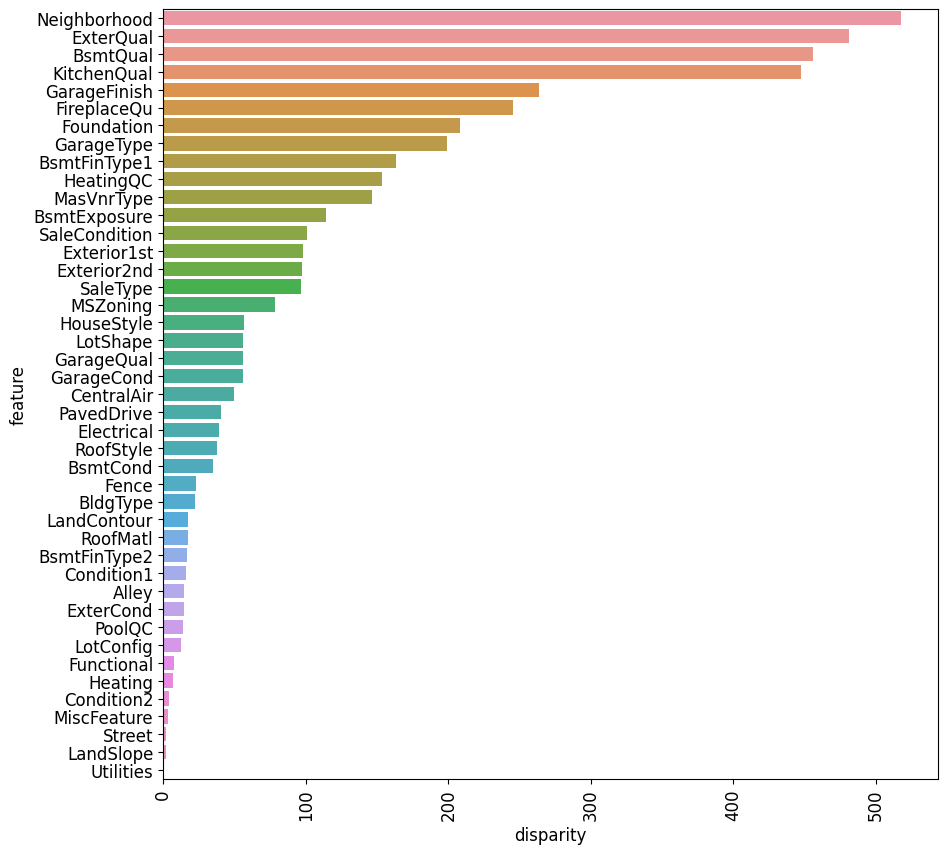

In [12]:
def anova(frame):
    '''
    - ANOVA is a statistical method used to determine 
    if there are any statistically significant differences 
    between the means of three or more independent (unrelated) groups
    '''
    anv=pd.DataFrame()
    anv['feature']=category_names
    p_values=[]
    for obj in category_names:
        samples=[] # accessor for SalePrices related to each values
        for values in frame[obj].unique():
            samples.append(frame[frame[obj]==values]['SalePrice'].values)
        p_values.append(st.f_oneway(*samples)[1]) 
        #one-way analysis of variance (ANOVA) is returned p-value <threshold meaning that \
        #There is a significant difference between the group means.")
    anv['p_values']=p_values
    return(anv.sort_values(by='p_values'))
fig, ax=plt.subplots(figsize=(10,10))
a=anova(df_train)
a['disparity']=np.log(1.0/a['p_values'].values)# large disparty value indicate ignificant difference
sns.barplot(data=a,y='feature',x='disparity',orient='h')
plt.xticks(rotation=90)

**[Comments]**:
- 1)checking with ANOVA test weahter sets have similar distributions. If variables has minor impact then set means should be equal. Decreasing P_VALU( increasing disparity) is a sign of increaisng diversity in partitions. In other words, features with high disparity values may be relevant.
- 2)Exclusively consider the categorical features, the majority of  features contain  one level dominated variable

**Numericals**

In [13]:
## numberical Features 
numeric_features=df_train.select_dtypes(include=[np.number])
numeric_features.drop('SalePrice',axis=1,inplace=True)
num_names=numeric_features.columns.tolist()
print("The number of numeric feature is ", numeric_features.shape[1])

The number of numeric feature is  36


     variable  value
0  MSSubClass   60.0
1  MSSubClass   20.0
2  MSSubClass   60.0
3  MSSubClass   70.0
4  MSSubClass   60.0


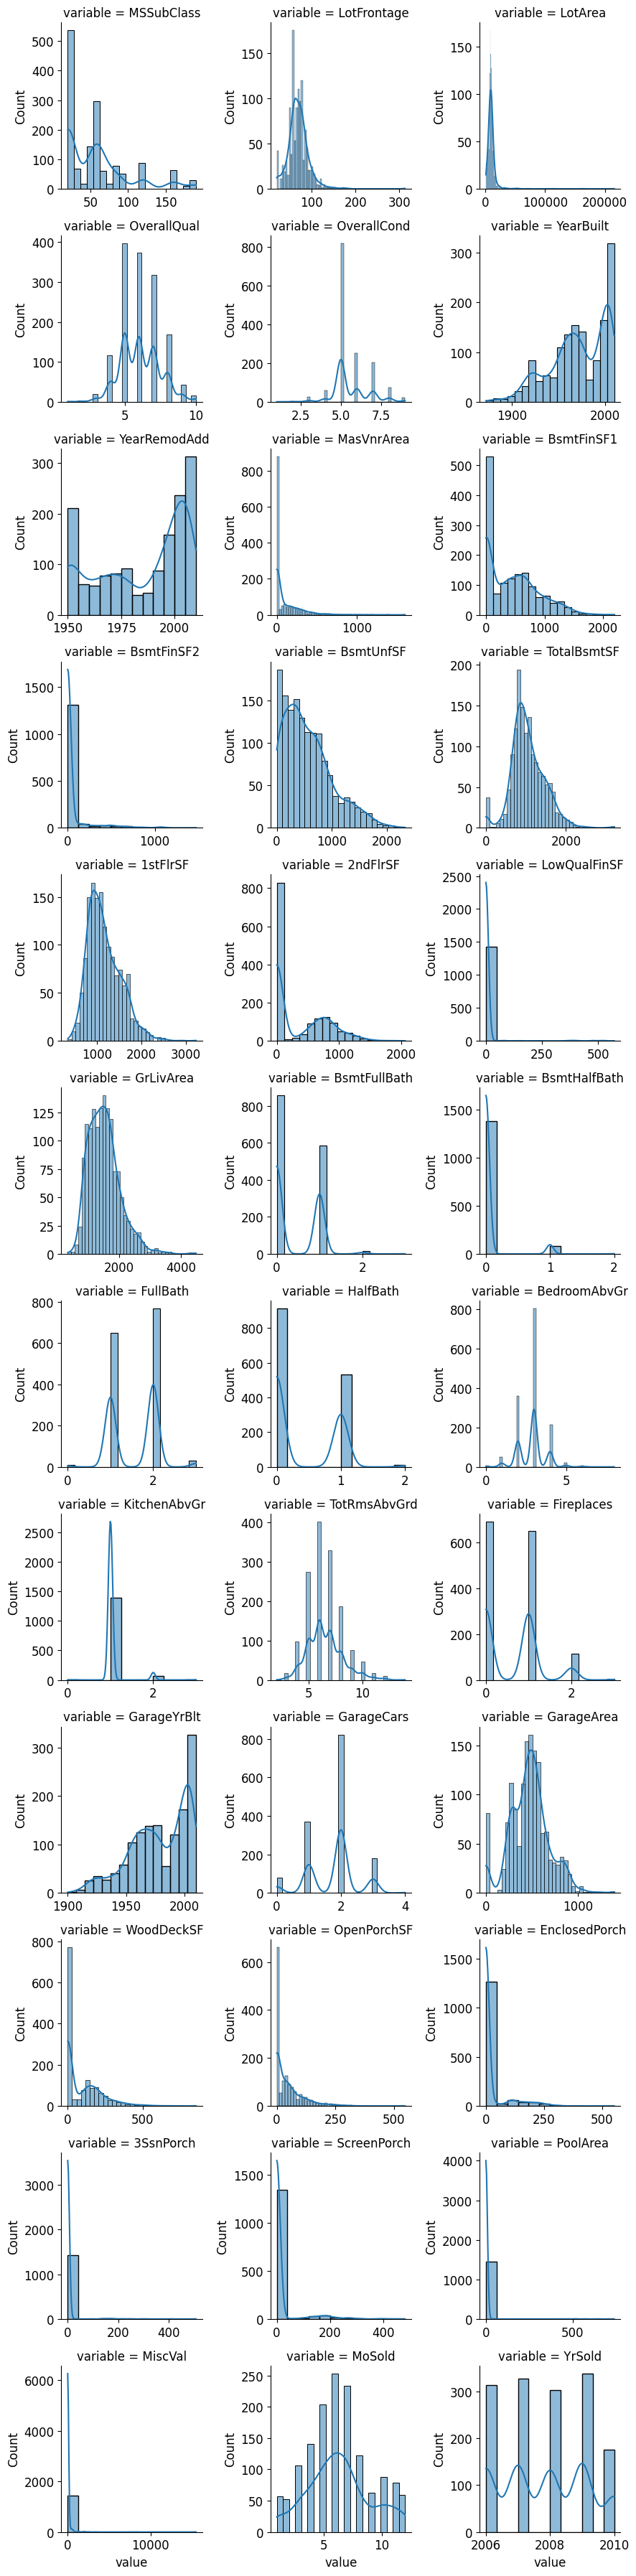

In [14]:
f=pd.melt(df_train,value_vars=num_names)
print(f.head())
g=sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False)
g=g.map(sns.histplot,"value",kde=True )

1stFlrSF      TotalBsmtSF     0.803830
GrLivArea     2ndFlrSF        0.694678
BsmtFullBath  BsmtFinSF1      0.658507
FullBath      GrLivArea       0.638378
HalfBath      2ndFlrSF        0.608830
TotRmsAbvGrd  2ndFlrSF        0.614034
              GrLivArea       0.829498
              BedroomAbvGr    0.680390
GarageYrBlt   YearBuilt       0.825317
              YearRemodAdd    0.641604
GarageCars    OverallQual     0.600741
GarageArea    GarageCars      0.887304
dtype: float64


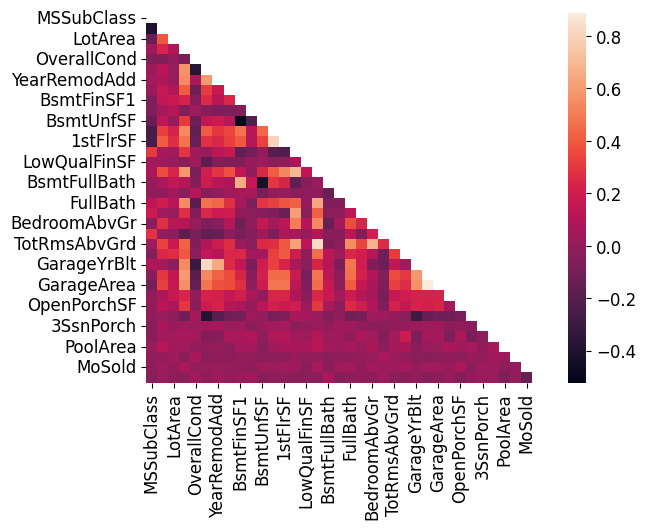

In [15]:
#plot correlation map
corr=numeric_features.corr()
mask = np.zeros_like(corr, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True
fig,ax1=plt.subplots()
sns.heatmap(corr,mask=mask,ax=ax1)

corr2=corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool_))
print(corr2[corr2.abs()>0.6].stack())


[[1.         0.79577427 0.73496816 0.65115291 0.64104701 0.63153038
  0.62921745 0.56216475 0.53776882 0.5236084 ]
 [0.79577427 1.         0.58941358 0.53859453 0.60074082 0.46909184
  0.55723004 0.54841971 0.4206215  0.57136809]
 [0.73496816 0.58941358 1.         0.40879348 0.47544152 0.53369718
  0.4563575  0.63837846 0.8294982  0.19439712]
 [0.65115291 0.53859453 0.40879348 1.         0.45188972 0.80382963
  0.47506909 0.32772043 0.26614613 0.40026576]
 [0.64104701 0.60074082 0.47544152 0.45188972 1.         0.44919454
  0.8873045  0.46819822 0.36115155 0.5373007 ]
 [0.63153038 0.46909184 0.53369718 0.80382963 0.44919454 1.
  0.47729916 0.38212    0.39638135 0.28125344]
 [0.62921745 0.55723004 0.4563575  0.47506909 0.8873045  0.47729916
  1.         0.4040763  0.32871405 0.47799759]
 [0.56216475 0.54841971 0.63837846 0.32772043 0.46819822 0.38212
  0.4040763  1.         0.55303847 0.46714602]
 [0.53776882 0.4206215  0.8294982  0.26614613 0.36115155 0.39638135
  0.32871405 0.55303847

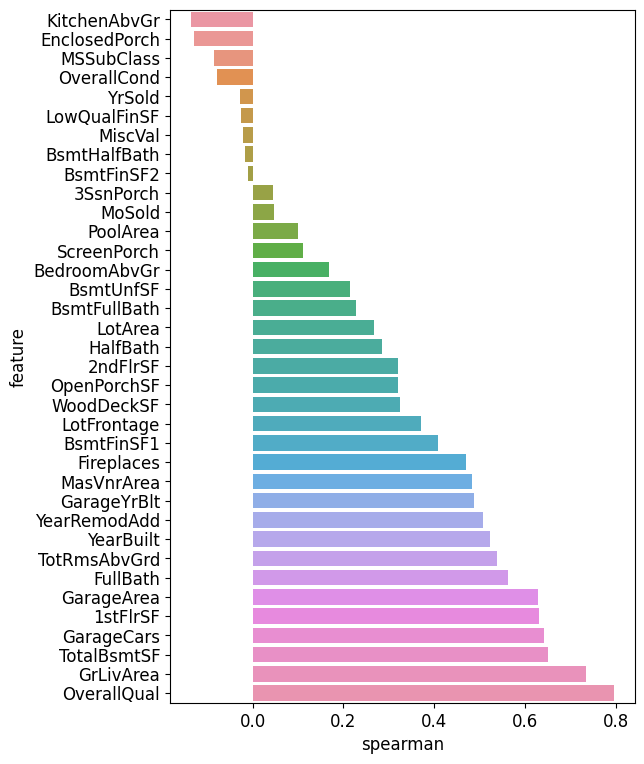

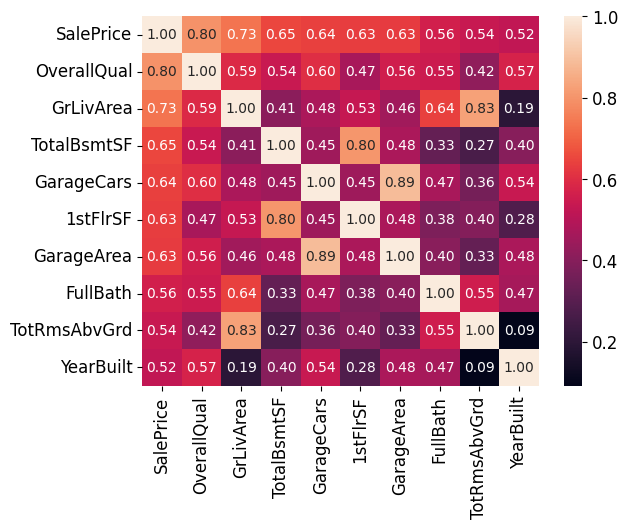

In [16]:
def spearman(feature_frame,names):
    '''idea from House Prices EDA
       get correlation of numerical values with SalePrice
       feature_frame=features + y_value
       '''
    spr=pd.DataFrame()
    # get feature name
    spr['feature']=names
    # get correlations
    spr['spearman']=[feature_frame[f].corr(feature_frame['SalePrice']) for f in names]
    spr.sort_values('spearman',inplace=True)
    
    plt.figure(  figsize=(6,0.25*len(names)))
    sns.barplot(data=spr,x='spearman',y='feature',orient='h')
    
# the correlations of numericla features with y_train_org

xy_train=pd.concat([numeric_features,y_train_org],axis=1)
spearman(xy_train,num_names)

fig,ax=plt.subplots()
corr_y_train=xy_train.corr()
k=10 # top 10 variable for plotting heatmap
 
cols=corr_y_train.nlargest(k,'SalePrice')['SalePrice'].index
 
cm=np.corrcoef(xy_train[cols].values.T)
sns.heatmap(cm,cbar=True,annot=True,fmt='.2f', annot_kws={'size':10},\
            yticklabels=cols.values,xticklabels=cols.values,\
           ax=ax)
print(cm)

**[Comments]**

A) Exclusively consider numerical features, 
- discrete/continuous distribution 
- TotalBsmtSF=BsmtFinSF1+BsmtFinSF1+BsmtUnfSF
-  strong correlated values: 
                              1stFlrSF vs TotalBsmtSF     0.801670
                              TotRmsAbvGrd  GrLivArea       0.808354
                              GarageYrBlt   YearBuilt       0.834812
                              GarageArea    GarageCars      0.889700
                              
 Actually, this correlcation is so strong that it can indicate a situation of multicollinearity, which mean these varibales can give almsost the same inforamtion. [action: delete one of twins]
 
B) Considering correlation with SalePrice
['SalePrice','OveraLLQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt'] 

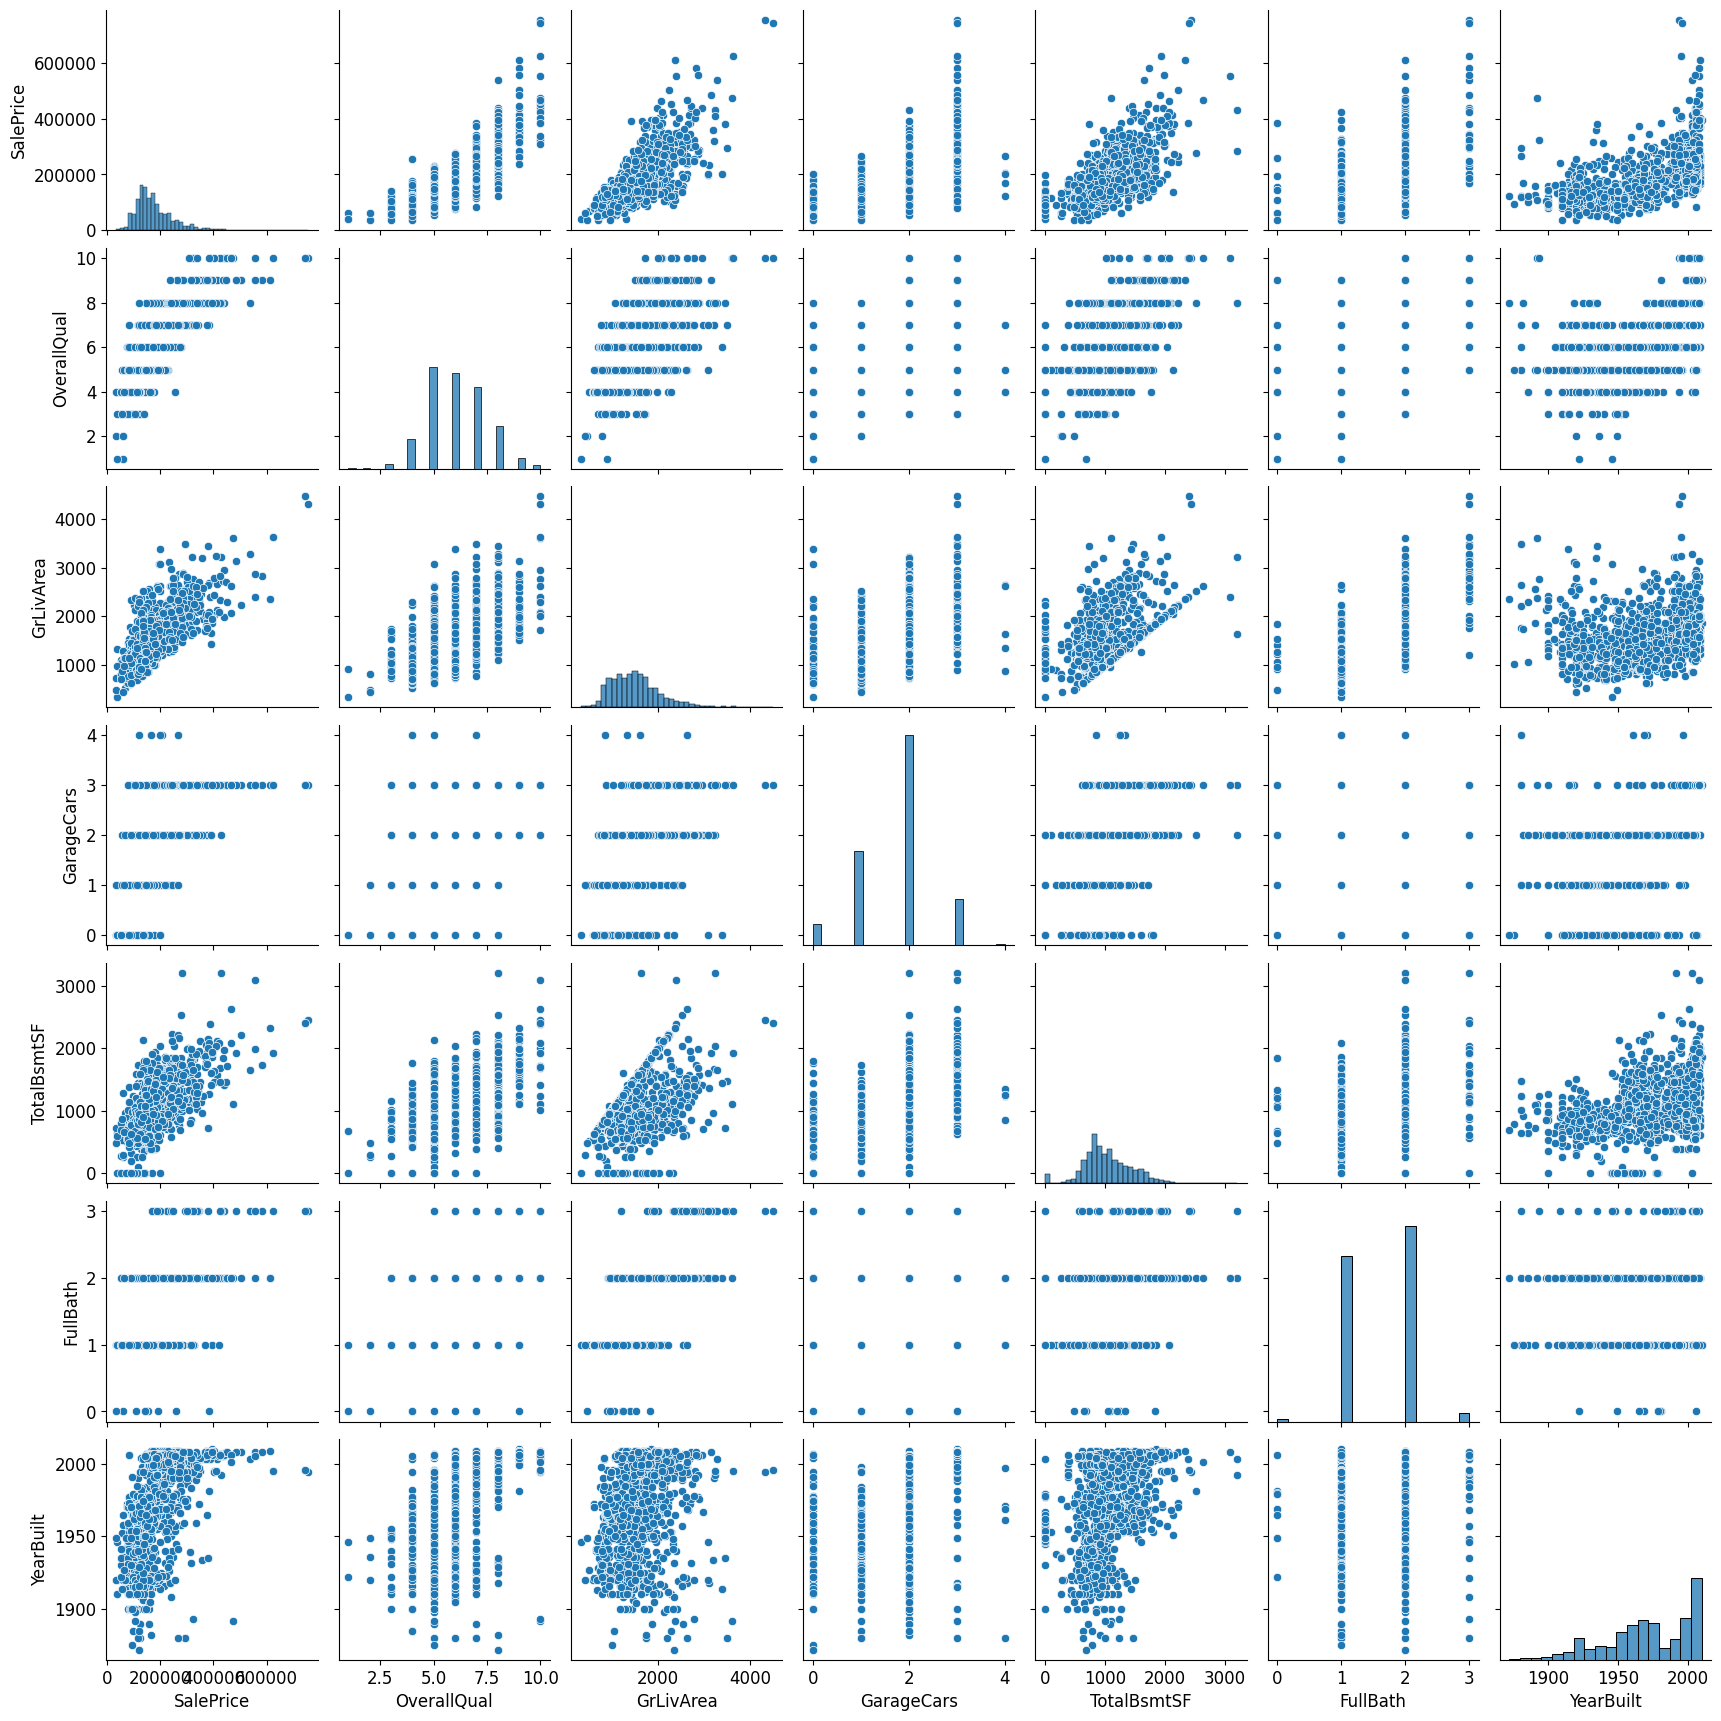

In [17]:
# Scatter plots between SalePrice and correlated variables
cols=['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']
# scine TotRmsAbvGrd,GarageArea,1stFlrSF, strongly correlated with GrLivArea,GarageCars and TotalBsmtSF,respectively
sns.pairplot(xy_train[cols],height=2.5)

## 1.3 Missing Values 
Let`s treat missing values for both train and text dataset

In [18]:
cateogryType(category_names,df_test)
combined=pd.concat([df_train.drop('SalePrice',axis=1),df_test],axis=0, ignore_index=True) # train [:-1459] ;test[1460:]
print(f"The size of the combined feature for train+test is {combined.shape}")

cateogryType(category_names,combined)
print(combined.info())

The size of the combined feature for train+test is (2917, 79)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     2917 non-null   int64   
 1   MSZoning       2917 non-null   category
 2   LotFrontage    2431 non-null   float64 
 3   LotArea        2917 non-null   int64   
 4   Street         2917 non-null   category
 5   Alley          2917 non-null   category
 6   LotShape       2917 non-null   category
 7   LandContour    2917 non-null   category
 8   Utilities      2917 non-null   category
 9   LotConfig      2917 non-null   category
 10  LandSlope      2917 non-null   category
 11  Neighborhood   2917 non-null   category
 12  Condition1     2917 non-null   category
 13  Condition2     2917 non-null   category
 14  BldgType       2917 non-null   category
 15  HouseStyle     2917 non-null   category
 16  OverallQual    2

In [19]:
def missValues(df):
    missedValues=df.isnull().sum()
    missedValues=missedValues[missedValues>0]
    try:
        if  len(missedValues)==0:
            print("No null value")
        else:
            missedValues.sort_values(inplace=True)
            fig,ax=plt.subplots( )
            missedValues.plot.barh()
    except:
          print("Request manually check")

[ Numericals]

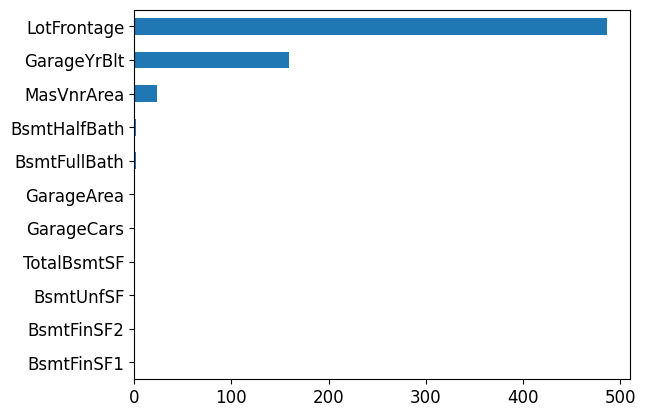

In [20]:
#  get the null value for numeeric features
missValues(combined.select_dtypes(include=[np.number]))

### Special values treatment 
Particuarly for the fetures where only few number of  values missing
- less than 100 
    * MasVnrArea  Masonry veneer area in square feet 23 
- more then 100
    * LotFrontage Linear feet of street connected to property 486
    * GarageYrBlt      159
- Based on the observation:  MasVnrArea NAN may indicate no MasVnr
 * MasVnrArea
 

Based on the feature missing values for Numerical features
- 1$^{st}$ type may indicate no existing where np.NAN can be filled by zero are because np.NaN

    - MasVnrArea(Masonry veneer area in square feet)
    - TotalBsmtSF(Total square feet of basement area)
    - BsmtFinSF1(Type 1 finished square feet)
    - BsmtFinSF2(Type 2 finished square feet)
    - BsmtUnfSF: Unfinished square feet of basement area
    - BsmtFullBath（Basement full bathrooms）
    - BsmtHalfBath（Basement half bathrooms
    - LotFrontage(Linear feet of street connected to property)


- 2$^{nd}$ type

    - GarageYrBlt (Year garage was built)
    
    - GarageCars (Size of garage in car capacity)
    - GarageArea (Size of garage in square feet)
   

 ### 1.3.1 Impute null_values for 1st type numerical values

In [21]:
imp_cont = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0,\
                         copy=False)
column_names=['LotFrontage','MasVnrArea','BsmtHalfBath','BsmtFullBath',\
              'TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtFullBath',\
              'BsmtHalfBath','BsmtUnfSF']
# imp_cont.fit_transform(combined[column_names])
combined[column_names]=imp_cont.fit_transform(combined[column_names])

 ### 1.3.2 Impute null_values for 2nd type numerical values

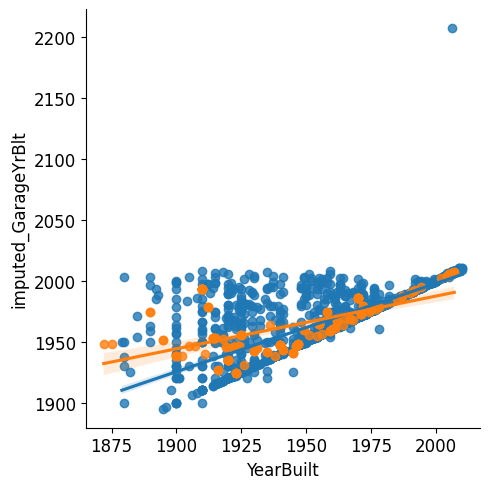

In [22]:
df=combined[['YearBuilt','GarageYrBlt']].copy()
 
df['is_missing']=df.GarageYrBlt.isnull()
imputerKNN = KNNImputer()

df['imputed_GarageYrBlt'] = imputerKNN.fit_transform(df)[:,1]
sns.lmplot(data=df, x='YearBuilt', y='imputed_GarageYrBlt', hue='is_missing', legend=False)

In [23]:
# the missing value for the 2nd type numerical values temperaturelly set to zero
column_names=['GarageCars','GarageArea']
combined[column_names]=imp_cont.fit_transform(combined[column_names])
# the missing value for the 2nd type numerical values temperaturelly set as the mean values
imp_mean = SimpleImputer(missing_values=np.NaN, strategy='mean',
                         copy=False)
# # the missing value for the 2nd type numerical values temperaturelly set as the mean values
# as GarageYrBlt strongly correlated with YearBuilt       0.834812

imputerKNN = KNNImputer(copy=False)
combined['GarageYrBlt']=imputerKNN.fit_transform(combined[['YearBuilt','GarageYrBlt']])
print(combined.select_dtypes(include=[np.number]).isnull().sum())

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64


**[Categoricals]**

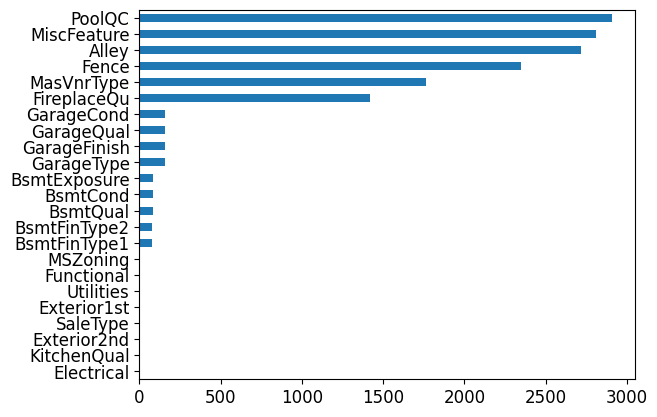

In [24]:
def count_NAinCat(df,names):
    f=df[names].copy()
    value_to_count='NA'
    count_per_column = f.apply(lambda col: col[col == value_to_count].count())
    count_per_column=count_per_column[count_per_column>0]
    count_per_column.sort_values(inplace=True)
    count_per_column.plot.barh()
    
count_NAinCat(combined,category_names)

In [25]:
combined['MasVnrType'].mask(combined['MasVnrArea'].astype(int) ==0,'NA',inplace=True)
combined['PoolQC'].mask(combined['PoolArea'].astype(int)==0,'NA',inplace=True)

combined['BsmtExposure'].mask( combined['TotalBsmtSF'].astype(int)==0,'NA',inplace=True)
combined['BsmtCond'].mask(combined['TotalBsmtSF'].astype(int)==0,'NA',inplace=True)
combined['BsmtQual'].mask(combined['TotalBsmtSF'].astype(int)==0,'NA',inplace=True)
combined['BsmtFinType1'].mask(combined['BsmtFinSF1'].astype(int)==0,'NA',inplace=True)
combined['BsmtFinType2'].mask(combined['BsmtFinSF2'].astype(int)==0,'NA',inplace=True)

combined['GarageQual'].mask(combined['GarageQual']==0,'NA',inplace=True)
combined['GarageType'].mask(combined['GarageQual']==0,'NA',inplace=True)
combined['GarageCond'].mask(combined['GarageQual']==0,'NA',inplace=True)
combined['FireplaceQu'].mask(combined['Fireplaces']==0,'NA',inplace=True)
combined['KitchenQual'].mask(combined['KitchenAbvGr']==0,'NA',inplace=True)
# get the null value for categorical features
 

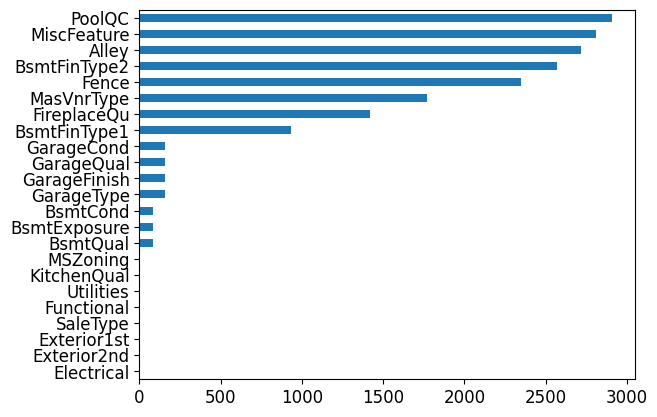

In [26]:
count_NAinCat(combined,category_names)

### Special values treatment 
particuarly for the fetures where only few number of  values missing, such as 

- MSZoning(4): The general zoning classification
- Utilities(2): Type of utilities available
- Exterior1st(1): Exterior covering on house
- Exterior2nd(1): Exterior covering on house (if more than one material)
- Electrical(1): Electrical system
- BsmtFinType2(1)
- BsmtQual(2):
- BsmtCond(3):
- BsmtExposure(3)
- PoolQC(3) 
- Functional(2): Home functionality (Assume typical unless deductions are warranted)


    
- For some features, missing values just indicate that the house probablity donot have these, you can impute the missing values as zero such as 

    - Alley (Alley: Type of alley access to property)
    - GarageQual (GarageQual: Garage quality)
    - GarageFinish
    - Fence
    - GarageCond
    - BsmtQual (Evaluates the height of the basement)
    
    
- other features it is safer to impute them with mode of the values:

In [27]:
imp_cont_SaleType = SimpleImputer(missing_values='NA', strategy='constant', fill_value='Oth',\
                         copy=False)
combined['SaleType']=pd.Series(
    imp_cont_SaleType.fit_transform(np.array(combined['SaleType']).reshape(-1,1)).reshape(-1)
        )

imp_cont_MasVnrType = SimpleImputer(missing_values='NA', strategy='constant', fill_value='None',\
                         copy=False)
combined['MasVnrType']=pd.Series(
    imp_cont_MasVnrType.fit_transform(np.array(combined['MasVnrType']).reshape(-1,1)).reshape(-1)
        )
#======

imp_cotStr= SimpleImputer( missing_values='NA',strategy='most_frequent',
                         copy=False)
modeValue4missed=['BsmtFinType2','BsmtCond','BsmtExposure',\
                  'BsmtQual','Exterior1st','Exterior2nd',\
          'MSZoning','KitchenQual','SaleType','Utilities',\
                  'Electrical','Functional','PoolQC']
combined[modeValue4missed]=imp_cotStr.fit_transform(combined[modeValue4missed])

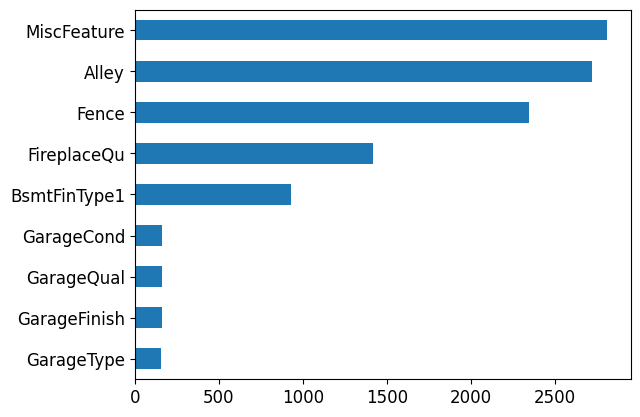

In [28]:
count_NAinCat(combined,category_names)

# 2 Preprecessing

(normalization, scaling for quantitative data, encoding categorical variable)

## 2.1 Distribution|Normality for y_train

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74213.25959976626, 180932.91906721535, 0.9320154492892366))

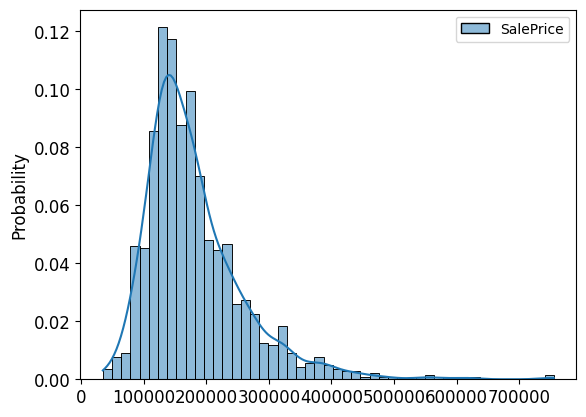

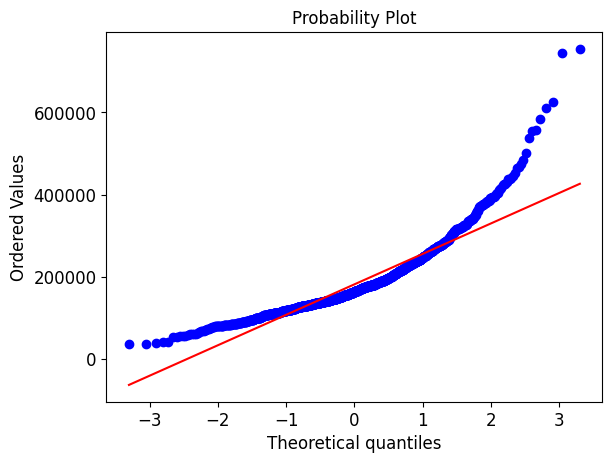

In [29]:
fig1,ax1=plt.subplots()
sns.histplot(y_train_org,kde=True,ax=ax1,stat='probability')
fig2,ax2=plt.subplots()
st.probplot(y_train_org['SalePrice'],plot=ax2)

   SalePrice
0  12.247694
1  12.109011
2  12.317167
3  11.849398
4  12.429216


((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([10.46024211, 10.47194981, 10.54270639, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.39853206929765145, 12.024008660964794, 0.9953918648311372))

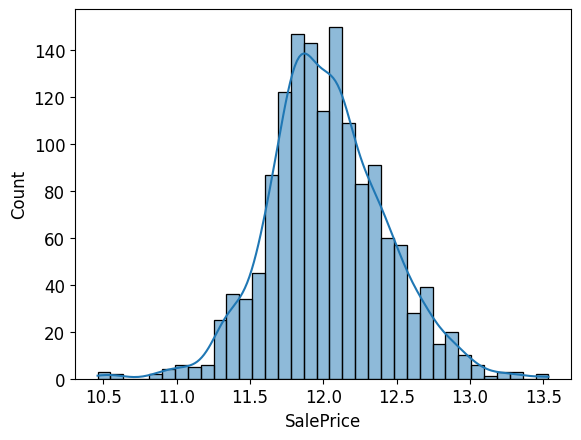

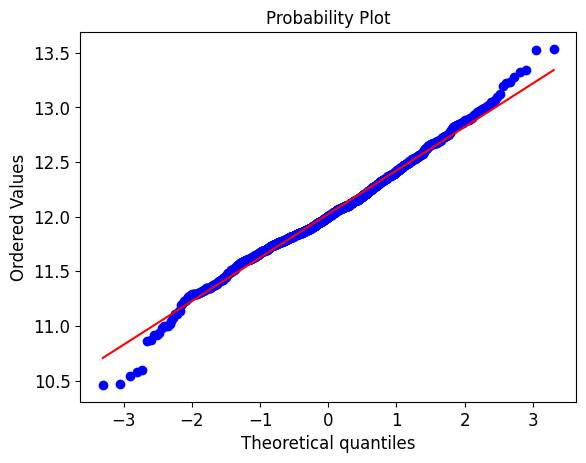

In [30]:
#Target values and correlation for numerical features in training set

y_train_log=y_train_org[['SalePrice']].applymap(lambda x: np.log(x))
print(y_train_log.head())
fig2,ax2=plt.subplots()
sns.histplot(y_train_log['SalePrice'],kde=True,ax=ax2)
y_train_log=y_train_log[['SalePrice']].copy()

fig3,ax3=plt.subplots()
st.probplot(y_train_log['SalePrice'],plot=ax3)


## 2.2 TimeSeries, Normalization and scaling for numerical varibales

### 2.2.1 Dealing with Time variables
There are 5 time variable in the dataset should be converted to age variable

In [31]:
combined['Age'] = combined.YrSold-combined.YearBuilt
combined['AgeRemod'] = combined.YrSold-combined.YearRemodAdd
combined['AgeGarage'] = combined.YrSold-combined.GarageYrBlt

print(combined['Age'][combined['Age']<0])
print(combined['AgeRemod'][combined['AgeRemod']<0])
print(combined['AgeGarage'][combined['AgeGarage']<0])

2547   -1
Name: Age, dtype: int64
2293   -1
2547   -2
Name: AgeRemod, dtype: int64
2547   -1.0
Name: AgeGarage, dtype: float64


In [32]:
combined.loc[2547,['Age','AgeRemod','AgeGarage']]=0
combined.loc[2293,'AgeRemod' ]=0
#  # 2547 and 2293 belong to test dataset 

In [33]:
combined.drop(['YearBuilt','YrSold','GarageYrBlt','YearRemodAdd'],axis=1,inplace=True)
print(f"The shape of the current dataset is {combined.shape}")
num_names=combined.select_dtypes(include=[np.number]).columns.tolist()

The shape of the current dataset is (2917, 78)


In [34]:
# log1p transform numerical values
def log1p_transform(feature):
    return(np.log1p(feature))
# quadraticaly transform numerical values
def quadratic(feature):
    return(lambda x: x**2)

In [35]:
st_scaler = StandardScaler()

In [36]:
y_train_log.shape

(1458, 1)

In [37]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [38]:
combined.loc[:1458,num_names]=combined.loc[:1458,num_names].applymap(
    lambda x:log1p_transform(x))
combined.loc[:1458, num_names]=st_scaler.fit_transform(
    combined.loc[:1458, num_names] )

In [39]:
combined.loc[1459:,num_names]=combined.loc[1459:,num_names].applymap(
    lambda x:log1p_transform(x))
combined.loc[1459:, num_names]=st_scaler.fit_transform(
    combined.loc[1459:, num_names] )

     variable     value
0  MSSubClass  0.425538
1  MSSubClass -1.123117
2  MSSubClass  0.425538
3  MSSubClass  0.646005
4  MSSubClass  0.425538


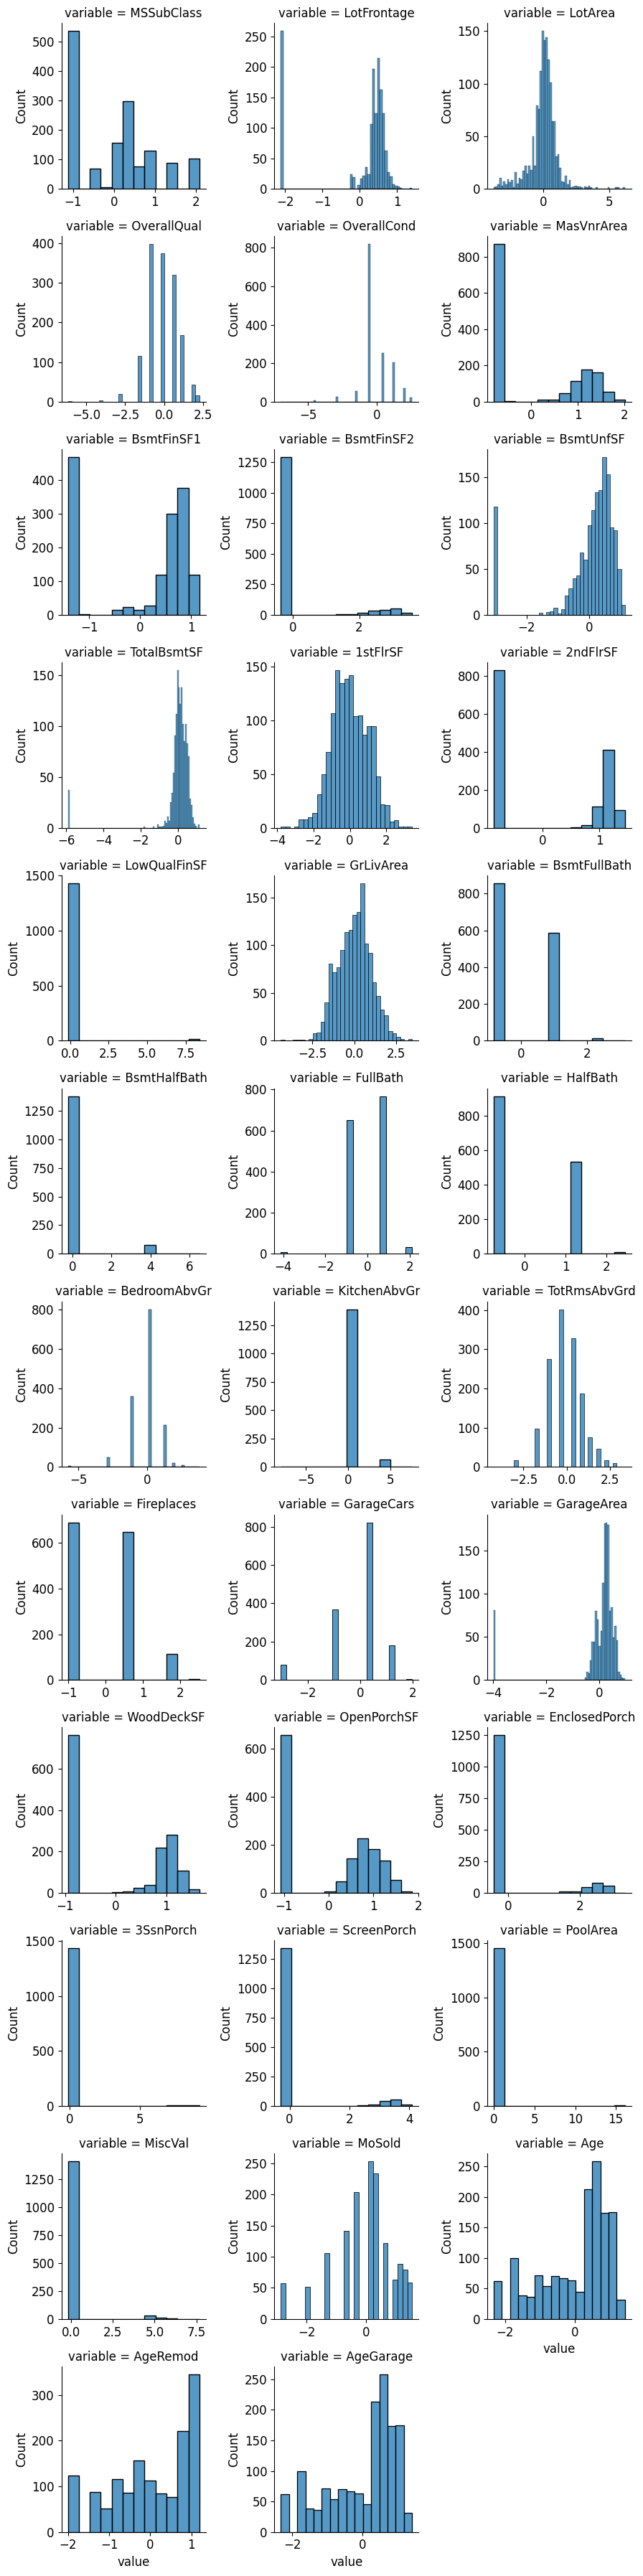

In [40]:
f=pd.melt(combined.loc[:1457,num_names],value_vars=num_names)
print(f.head())
g=sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False)
g=g.map(sns.histplot,"value")

## 2.3  Transformin categorical variables to numerical

most of ML algrothms can only read numerical values

- For some cateogrical features which show rank properties for example “Fa” is better than “Po” and “TA” is better than “Fa”.
    - BsmtQual 
    - HeatingQC
    - Fence: Fence quality
    - PoolQC: Pool quality
    - GarageQual
    - GarageType 
    - GarageCond
    - GarageFin
    - Functional(Home functionality (Assume typical unless deductions are warranted)
    - LandSlope: Slope of property
    - Utilities :Type of utilities available
    - Neighborhood: Physical locations within Ames city limits
    - LotConfig: Lot configuration
    - LandContour: Flatness of the propert
    - Foundation： Type of foundation
    - CentralAir
    - Electrical: Electrical system
    - GarageType:Garage location
    - FireplaceQu
    - BldgType: Type of dwelling
    - SaleType(Type of sale)
    - ExterQual (Evaluates the quality of the material on the exterior)
    - ExterCond: Evaluates the present condition of the material on the exterior
    - BsmtFinType1
    - BsmtFinType2
    - BsmtExposure
    - PavedDrive
    - Fence 
- other may have preference
     - Street： Type of road access to property
     
     - Neighborhood 
     - Condition1
     - Condition2
     - Exterior1st
     - Exterior2nd
     - MSZoning （Identifies the general zoning classification of the sale.）
     - MasVnrType
     - Heating
     - MiscFeature
     - SaleCondition  
    - LotShape: General shape of property
    - Heating: Type of heating
    - RoofStyle: Type of roof
    - RoofMatl: Roof materia

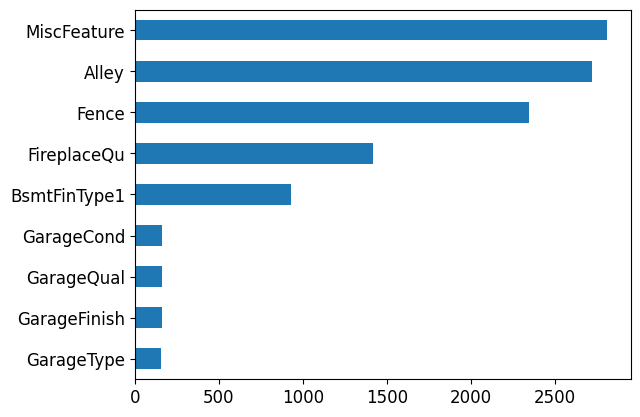

In [41]:
count_NAinCat(combined,category_names)

In [42]:
# For categorical variables with strong ranking preference 
GarageFinish={'NA':0,'Unf':1,'RFn':2,'Fin':3}
Evaluates ={'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
Fence={'NA':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4 }
LandSlope={'Sev':0,'Mod':1,'Gtl':2}
Electrical={'Mix':0,'FuseP':1,'FuseF':2,'FuseA':3,'SBrkr':4}
Foundation={'Wood':0,'Stone':1,'Slab':2,'PConc':3,'CBlock':4,'BrkTil':5}
Functional={'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}
GarageType={'NA':0,'Detchd':1, 'CarPort':2,'BuiltIn':3,'Basment':4,\
            'Attchd':5,'2Types':6}
BsmtFinType={'NA':0,'Unf':2,'LwQ':3,'Rec':4,'BLQ':5,'ALQ':6,'GLQ':7}
BsmtExposure={'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4}
RateToNums={'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
SaleType={'Oth':0,'ConLD':1,'ConLI':2,'ConLw':3,'Con':4,'COD':5,\
         'New':6,'VWD':7,'CWD':8,'WD':9}
LandContour={'Low':0,'HLS':1,'Bnk':2,'Lvl':3}
LotConfig={'FR3':0,'FR2':1,'CulDSac':2,'Corner':3,'Inside':4}
Utilities={'ELO':0,'NoSeWa':1,'NoSewr':2,'AllPub':3}
column_mappings = {
    'LotConfig':LotConfig,
    'Alley': {'NA': 0, 'Grvl': 1, 'Pave': 2},
    'BsmtQual': Evaluates,
    'GarageQual': Evaluates,
    'GarageCond':Evaluates,
    'PoolQC': Evaluates,
    'KitchenQual':Evaluates,
    'FireplaceQu':Evaluates,
    'BsmtFinType1':Evaluates,
    'Fence':Fence,
    'HeatingQC':Evaluates,
    'CentralAir':{'N':0,'Y':1},
    'Electrical':Electrical,
    'Functional':Functional,
    'GarageType':GarageType,
    'FireplaceQu':Evaluates,
    'SaleType':SaleType,
    'LandContour':LandContour,
    'Utilities':Utilities,
    'ExterQual':Evaluates,
    'ExterCond':Evaluates,
    'Foundation':Foundation,
    'BsmtQual':Evaluates,
    'BsmtCond':Evaluates,
    'BsmtFinType1':BsmtFinType,
    'BsmtFinType2':BsmtFinType,
    'KitchenQual':Evaluates,
    'PavedDrive':{'N':0,'P':1,'Y':2},
    'LandSlope':LandSlope,
    'BsmtExposure':BsmtExposure,
    'GarageFinish':GarageFinish
    
}

for column, mapping in column_mappings.items():
    combined[column] = combined[column].map(mapping)

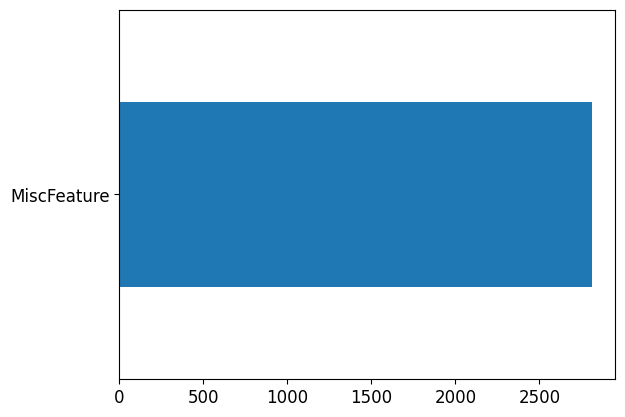

In [43]:
count_NAinCat(combined,category_names)

In [44]:
catnames=['Street','Neighborhood', 'Condition1', 'Condition2', 'Exterior1st',\
          'Exterior2nd','MSZoning','Heating','MiscFeature','SaleCondition',\
        'LotShape', 'Heating','RoofStyle', 'RoofMatl','HouseStyle','MasVnrType','BldgType']

for cat in catnames:
    if cat in combined.columns.tolist():
#         print(cat)
        dummy_df=pd.get_dummies(combined[cat],prefix=cat+"_",dtype=float)
        combined = pd.concat([combined, dummy_df], axis=1)
        combined.drop(cat,axis=1,inplace=True)
        
for i in combined.columns.tolist():
    if combined[i].dtype=='category':
#         print(i)
        print(combined[i].unique())
        combined[i]=combined[i].astype(int)

[0, 1, 2]
Categories (3, int64): [1, 2, 0]
[3, 2, 0, 1]
Categories (4, int64): [2, 1, 0, 3]
[4, 1, 3, 2, 0]
Categories (5, int64): [3, 2, 1, 0, 4]
[2, 1, 0]
Categories (3, int64): [2, 1, 0]
[4, 3, 5, 2]
Categories (4, int64): [5, 2, 4, 3]
[3, 4, 2, 1, 5]
Categories (5, int64): [5, 2, 4, 1, 3]
[3, 4, 5, 0, 2, 1]
Categories (6, int64): [5, 4, 3, 2, 1, 0]
[7, 6, 0, 4, 5, 3]
Categories (7, int64): [6, 5, 7, 3, 4, 2, 0]
[5, 4, 3, 2, 1]
Categories (5, int64): [5, 2, 4, 1, 3]
[1, 0]
Categories (2, int64): [0, 1]
[0, 3, 4, 2, 5, 1]
Categories (6, int64): [5, 2, 4, 1, 3, 0]
[5, 1, 3, 2, 0, 4, 6]
Categories (7, int64): [6, 5, 4, 3, 2, 1, 0]
[2, 1, 3, 0]
Categories (4, int64): [3, 2, 1, 0]
[3, 2, 4, 0, 5, 1]
Categories (6, int64): [5, 2, 4, 0, 1, 3]
[3, 2, 0, 4, 1, 5]
Categories (6, int64): [5, 2, 4, 1, 3, 0]
[2, 0, 1]
Categories (3, int64): [0, 1, 2]
[0, 3, 2, 4, 1]
Categories (5, int64): [4, 2, 3, 1, 0]


In [45]:
missValues(combined.select_dtypes(include=[np.number]))

No null value


# 3. Feature engineering 
so far, we should note that 
- 1) test and train dataset has been all collected in combined [:1457]
- 2) y_train_log is the transformed y_train

## 3.2 Removing unimportant features

In [46]:
try:
    combined.select_dtypes(exclude=[np.number]).describe()
except:
    
    print("No cat-feature")

No cat-feature


Note:  
                       
                       1stFlrSF vs TotalBsmtSF     0.801670
                       TotRmsAbvGrd  GrLivArea       0.808354
                       GarageYrBlt   YearBuilt       0.834812
                       GarageArea    GarageCars    
we can only key one of each pair as they are strongly correlated,drop strongly correlated features

In [47]:
combined.drop(['TotalBsmtSF','TotRmsAbvGrd','GarageCars'],axis=1,inplace=True)

In [48]:
missValues(combined.select_dtypes(include=[np.number]))

No null value


In [49]:
X_train=combined.iloc[:1458].reset_index(drop=True)
X_test=combined[1458:].reset_index(drop=True)
print(X_train.shape)
print(y_train_log.shape)
y_train_log.reset_index(drop=True,inplace=True)

(1458, 190)
(1458, 1)


In [50]:
# use traning set 
xgb_reg=xgb.XGBRegressor()
xgb_reg.fit(X_train,y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

                        Importance
OverallQual               0.326522
CentralAir                0.097258
KitchenQual               0.092032
ExterQual                 0.043429
GarageFinish              0.034781
GrLivArea                 0.031723
MSZoning__RM              0.029484
MSZoning__C (all)         0.028000
GarageType                0.020281
Fireplaces                0.018624
Neighborhood__IDOTRR      0.018074
FireplaceQu               0.013125
GarageArea                0.011941
BsmtQual                  0.011914
LotShape__Reg             0.011243
1stFlrSF                  0.011028
Age                       0.010129
BsmtFinSF1                0.010024
OverallCond               0.010000
KitchenAbvGr              0.009337
Condition1__Artery        0.007055
Neighborhood__Crawfor     0.006981
SaleCondition__Abnorml    0.005862
BsmtFinType1              0.005332
AgeRemod                  0.004806


Text(0, 0.5, 'Importance')

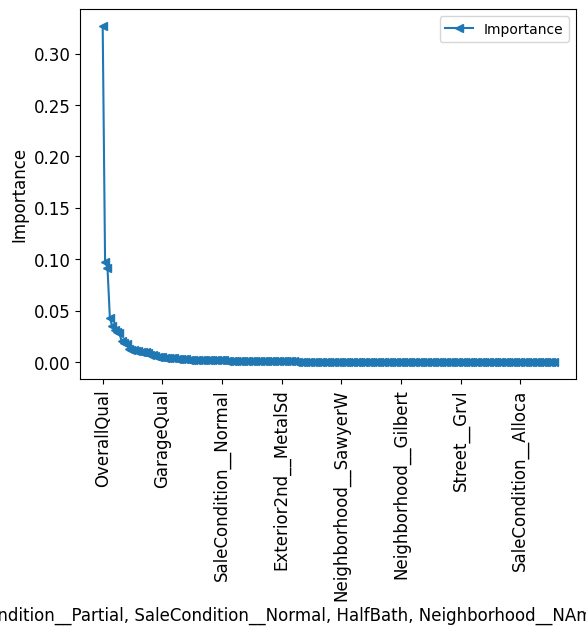

In [51]:
imp_features= pd.DataFrame(xgb_reg.feature_importances_ ,\
                           columns = ['Importance'],index = X_train.columns)
imp_features = imp_features.sort_values(['Importance'], ascending = False)
imp_features.plot(xlabel=imp_features.index,marker='<')
print(imp_features.head(25))
plt.xticks(rotation=90) 
plt.ylabel('Importance') 

In [52]:
# using RFECV to determine the optimal number of features
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, mean_squared_error

def rmse(y_train,y_pred):
    return(mean_squared_error(y_train,y_pred,squared=False))


In [53]:
costom_scorer_obj=make_scorer(rmse,greater_is_better=False)
min_features_to_select=5
rfecv=RFECV(xgb_reg,step=1,cv=5,verbose=False, scoring=costom_scorer_obj,\
            min_features_to_select = min_features_to_select)
rfecv.fit(X_train,y_train_log)
print("Optimal number of features : %d" %rfecv.n_features_)

Optimal number of features : 42


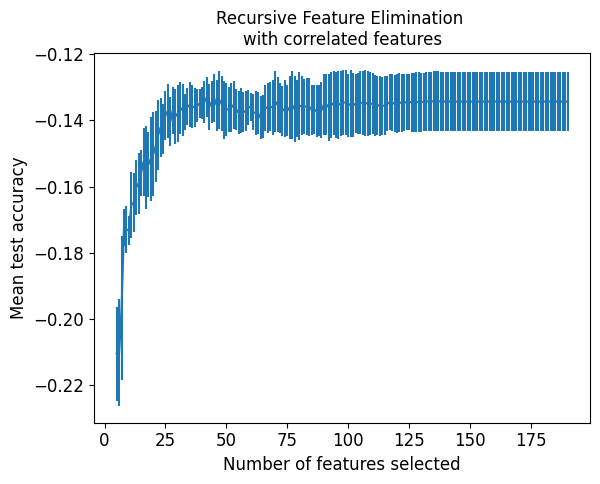

In [54]:
rfecv.cv_results_.keys()
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()
features_kept = X_train.columns.values[rfecv.support_] 
X_train_imp= X_train[features_kept]
X_test_imp=X_test[features_kept]

In [55]:
missValues( X_train_imp.select_dtypes(include=[np.number]))

No null value


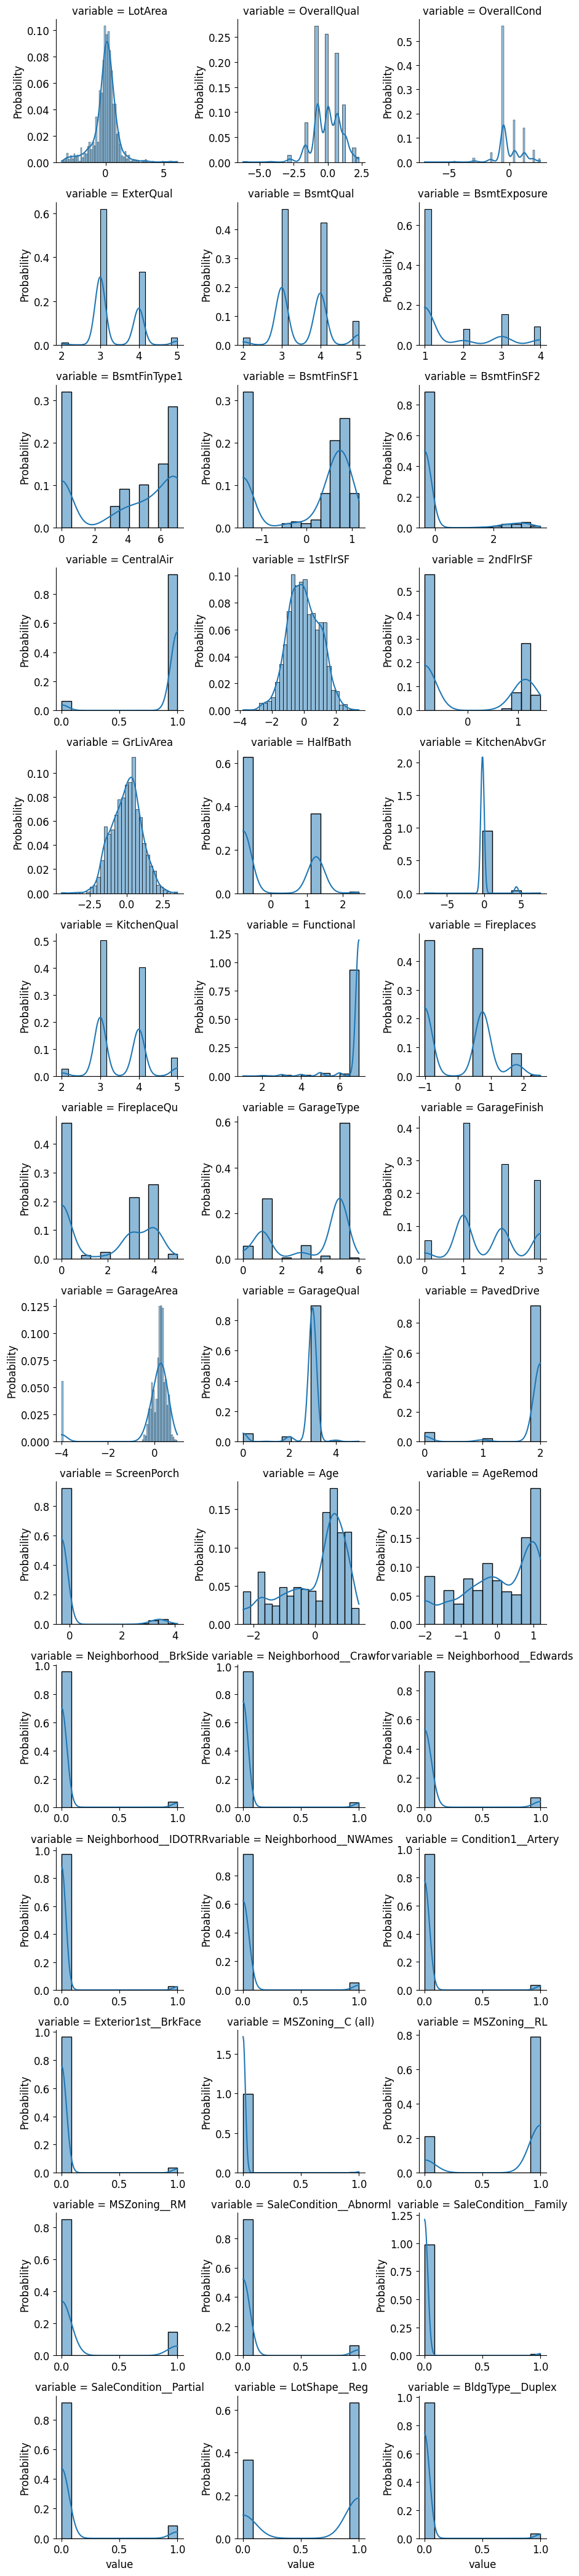

In [56]:
f=pd.melt(X_train_imp,value_vars=X_train_imp.columns.tolist())
g=sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False)
g=g.map(sns.histplot,"value",kde=True,stat='probability')

In [57]:

print(X_train_imp.shape)
y_train_log.head()
print(y_train_log.shape)
y_train=np.array(y_train_log).reshape(-1)

(1458, 42)
(1458, 1)


# Split the data into training and validation sets

In [58]:
# spliting the train dataset into training and validation 
def split_dataset(dataset,validation_ratio=0.3):
    validation_indices=np.random.rand(len(dataset)) < validation_ratio
    return(dataset[~validation_indices],dataset[validation_indices] )
train=pd.concat([X_train_imp.reset_index(drop=True),y_train_log.reset_index(drop=True)],
                                                axis=1 )
train_ds_pd,valid_ds_pd=split_dataset(train)
print(f"{train_ds_pd.shape} in training, {valid_ds_pd.shape} in validating")

(1043, 43) in training, (415, 43) in validating


# Baseline Lasso

In [59]:
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model,X,y):
    rmse=np.sqrt(-cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error'))
    print(rmse)
    return(rmse)

- lasso_model

In [60]:
alphas=[0.05, 0.1,0.5,1,5,10,15,30]
lasso_model=LassoCV(alphas=alphas,cv=5).fit(train_ds_pd.iloc[:, :-1],
                                            train_ds_pd['SalePrice'])

In [61]:
print(f" rmse for lassco is {rmse_cv(lasso_model,train_ds_pd.iloc[:, :-1],train_ds_pd['SalePrice']).mean():.2f}")
print(f" rmse for lassco is\
 {rmse(lasso_model.predict(valid_ds_pd.iloc[:, :-1]),valid_ds_pd['SalePrice']):.2f}"
     )

[0.16909307 0.18584293 0.17003192 0.15973724 0.16086391]
 rmse for lassco is 0.17
 rmse for lassco is 0.15


In [62]:
print(f"alpha for lasso is {lasso_model.alpha_}")
coef_lasso=pd.Series(lasso_model.coef_, index=X_train_imp.columns )
print(f"{sum(coef_lasso != 0)}  coef >0 and {sum(coef_lasso == 0)} coef ==0 ")

alpha for lasso is 0.05
9  coef >0 and 33 coef ==0 


<Axes: >

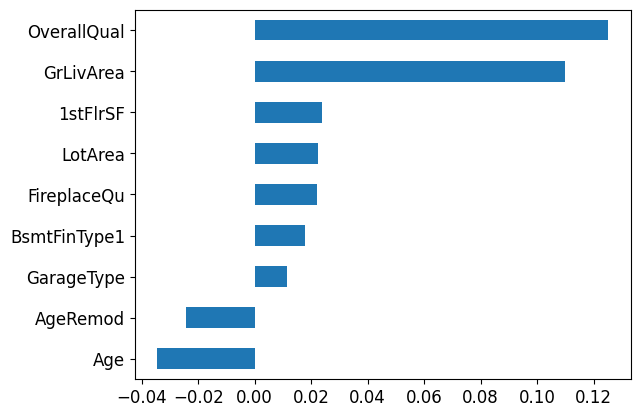

In [63]:
imp_coef_lasso=coef_lasso[coef_lasso!=0].sort_values()
imp_coef_lasso.plot(kind='barh')

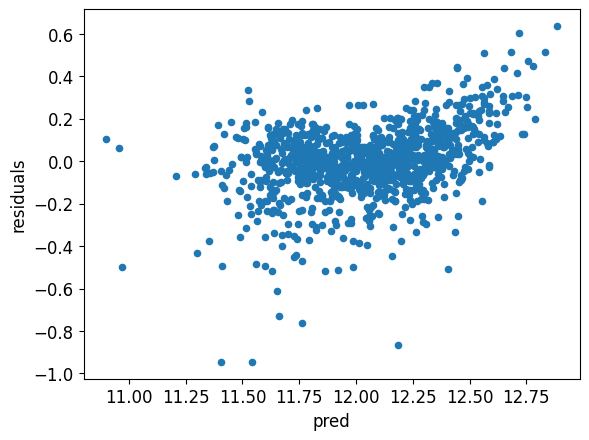

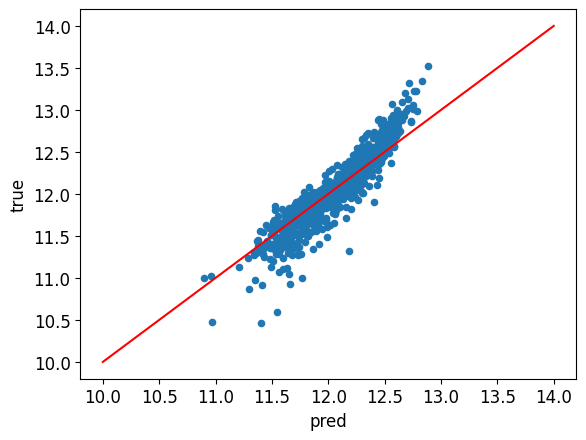

In [64]:
comparsion=pd.DataFrame({'pred':lasso_model.predict(train_ds_pd.iloc[:, :-1]),
                         'true':train_ds_pd['SalePrice']})
comparsion['residuals']=comparsion['true']-comparsion['pred']
comparsion.plot(x='pred',y='residuals',kind='scatter')
fig,ax=plt.subplots()
comparsion.plot(x='pred',y='true',kind='scatter',ax=ax)
ax.plot([10,14],[10,14],c='r')

# XGBRegressor

In [65]:
params = {"max_depth": 2, "eta": 0.05} #Booster params.
xgbcv=xgb.cv(params=params,
             dtrain=xgb.DMatrix(train_ds_pd.iloc[:, :-1],
                                label=train_ds_pd['SalePrice']),
             num_boost_round=500,
             nfold=5,
             early_stopping_rounds=50)

<Axes: >

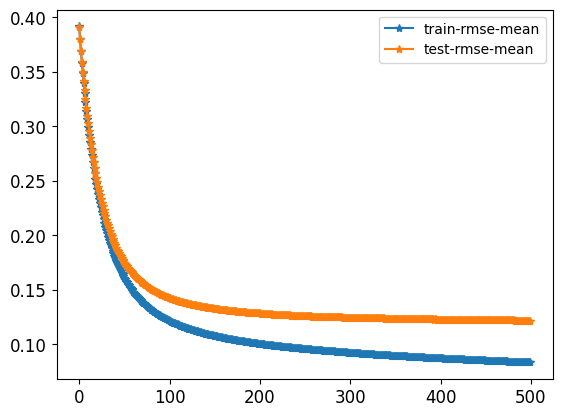

In [66]:
xgbcv[['train-rmse-mean','test-rmse-mean']].plot(marker='*')

In [67]:
# no tuning hyper-parameter
xgb_model=xgb.XGBRegressor(n_estimators=300,
                           max_depth=2,
                           learning_rate=0.05,
                          eval_metric=mean_squared_error)
xgb_model.fit(train_ds_pd.iloc[:, :-1],
              train_ds_pd['SalePrice']
             )
print(f"rmse for  xgb_model train is \
{xgb_model.score(train_ds_pd.iloc[:, :-1],train_ds_pd['SalePrice']):.2f}")
print(f"rmse for  xgb_model validation is \
{rmse(xgb_model.predict(valid_ds_pd.iloc[:, :-1]),valid_ds_pd['SalePrice']):.2f}")

rmse for  xgb_model train is 0.94
rmse for  xgb_model validation is 0.12


                        Importance
GarageFinish              0.186368
KitchenQual               0.161741
OverallQual               0.150268
ExterQual                 0.076494
GarageType                0.061962
FireplaceQu               0.054652
BsmtQual                  0.047628
GrLivArea                 0.044015
CentralAir                0.037534
MSZoning__RL              0.024192
GarageArea                0.020532
AgeRemod                  0.018976
GarageQual                0.015657
1stFlrSF                  0.014797
BsmtFinSF1                0.014011
Age                       0.009028
LotArea                   0.006906
MSZoning__C (all)         0.006763
OverallCond               0.006519
BsmtFinType1              0.005960
SaleCondition__Partial    0.004718
Fireplaces                0.004403
LotShape__Reg             0.003118
Neighborhood__Crawfor     0.002497
SaleCondition__Abnorml    0.002497


Text(0, 0.5, 'Importance')

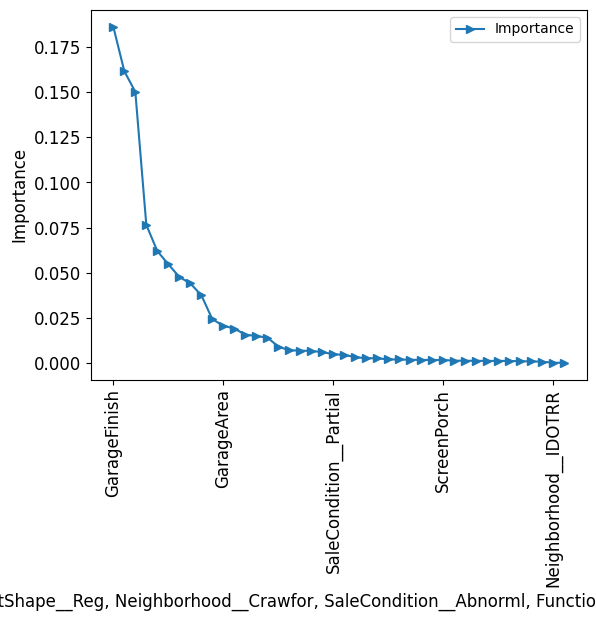

In [68]:
imp_features= pd.DataFrame(xgb_model.feature_importances_ ,
                           columns = ['Importance'],
                           index = train_ds_pd.iloc[:, :-1].columns)
imp_features = imp_features.sort_values(['Importance'], ascending = False)
imp_features.plot(xlabel=imp_features.index,marker=">")
print(imp_features.head(25))
plt.xticks(rotation=90) 
plt.ylabel('Importance') 

# RF Model
One should note that data set containing a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML

In [69]:
# convert df  to tensorFlow DataSet 
#TensorFlow Datasets is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.
label='SalePrice'
train_ds=tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd,
                                               label=label,
                                        task=tfdf.keras.Task.REGRESSION)
valid_ds=tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd,
                                               label=label,
                                    task=tfdf.keras.Task.REGRESSION)

In [70]:
# List all model in tfdf 
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## Creat Random Forest

In [71]:
#tfdf has good defaults for hyperparameters
tfdf_rf_model = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",
                                  task=tfdf.keras.Task.REGRESSION)
tfdf_rf_model.compile(metrics=['mse'])

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpei_mu06m as temporary training directory


In [72]:
tfdf_rf_model.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:07.940804. Found 1043 examples.
Training model...


[INFO 24-01-05 00:35:56.2856 UTC kernel.cc:1243] Loading model from path /tmp/tmpei_mu06m/model/ with prefix d8c8f365075f4bc6


Model trained in 0:00:03.946461
Compiling model...


[INFO 24-01-05 00:35:56.9867 UTC decision_forest.cc:660] Model loaded with 300 root(s), 99380 node(s), and 42 input feature(s).
[INFO 24-01-05 00:35:56.9868 UTC abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 24-01-05 00:35:56.9868 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


- Visualze the tfdf_rf_model

One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

a "sparse oblique split" means that the decision tree algorithm considers only a subset of features at each node, and the split is not necessarily aligned with the coordinate axes. This allows the decision tree to capture more complex relationships between features and improve its ability to model non-linear decision boundaries

In [73]:
tfdf.model_plotter.plot_model_in_colab(tfdf_rf_model, tree_idx=0, max_depth=3)

In [74]:
#The training logs show the Root Mean Squared Error (RMSE) 
#evaluated on the out-of-bag dataset 
#according to the number of trees in the model.

inspector4rf=tfdf_rf_model.make_inspector()
print(inspector4rf.variable_importances().keys())
inspector4rf.variable_importances()['NUM_AS_ROOT']


dict_keys(['INV_MEAN_MIN_DEPTH', 'NUM_AS_ROOT', 'SUM_SCORE', 'NUM_NODES'])


[("OverallQual" (1; #36), 96.0),
 ("ExterQual" (1; #12), 42.0),
 ("GrLivArea" (1; #21), 35.0),
 ("Age" (1; #2), 17.0),
 ("BsmtQual" (1; #9), 16.0),
 ("1stFlrSF" (1; #0), 15.0),
 ("KitchenQual" (1; #24), 11.0),
 ("BldgType__Duplex" (1; #4), 7.0),
 ("GarageArea" (1; #17), 6.0),
 ("Neighborhood__Crawfor" (1; #31), 6.0),
 ("CentralAir" (1; #10), 5.0),
 ("GarageQual" (1; #19), 5.0),
 ("Condition1__Artery" (1; #11), 4.0),
 ("Fireplaces" (1; #15), 4.0),
 ("LotArea" (1; #25), 4.0),
 ("AgeRemod" (1; #3), 3.0),
 ("Neighborhood__BrkSide" (1; #30), 3.0),
 ("Neighborhood__IDOTRR" (1; #33), 3.0),
 ("Neighborhood__NWAmes" (1; #34), 3.0),
 ("Exterior1st__BrkFace" (1; #13), 2.0),
 ("FireplaceQu" (1; #14), 2.0),
 ("HalfBath" (1; #22), 2.0),
 ("KitchenAbvGr" (1; #23), 2.0),
 ("MSZoning__RL" (1; #28), 2.0),
 ("MSZoning__RM" (1; #29), 2.0),
 ("BsmtFinSF2" (1; #7), 1.0),
 ("MSZoning__C_(all)" (1; #27), 1.0),
 ("Neighborhood__Edwards" (1; #32), 1.0)]

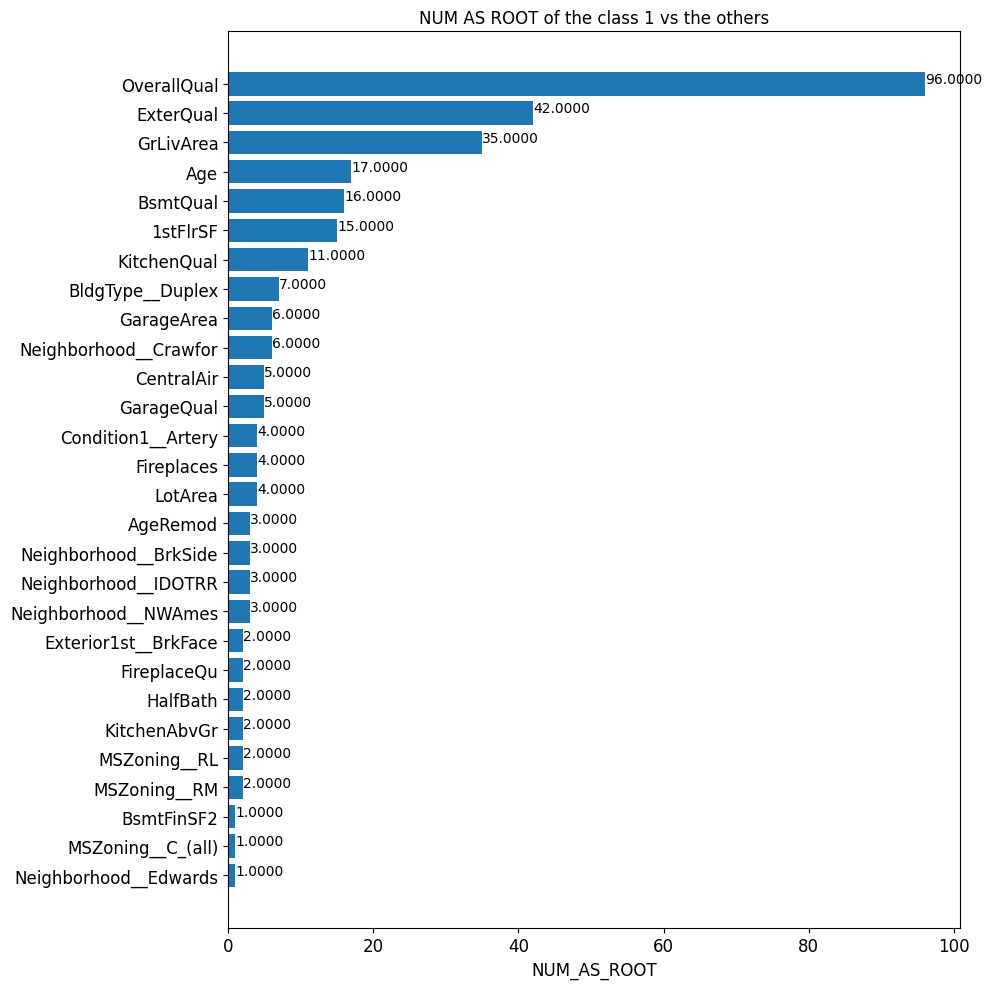

In [75]:
# Plot the variable importances 
fig,ax=plt.subplots(figsize=(10,10))
variable_importance_metric='NUM_AS_ROOT'
variable_importances=inspector4rf.variable_importances()[variable_importance_metric]
# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = ax.barh(feature_ranks, feature_importances, \
              label=[str(x) for x in feature_ranks])
ax.set_yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(),\
         f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

The important features for the Variable Importance **NUM_AS_ROOT**. 

The larger the importance score for **NUM_AS_ROOT**, the more impact it has on the out come of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

The training logs show the quality of the model

Text(0, 0.5, 'RMSE (out of bag)')

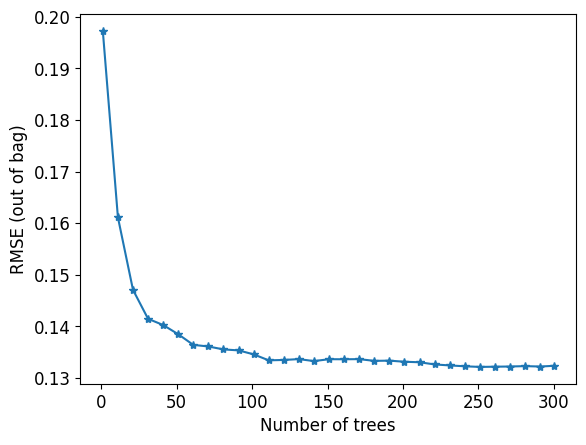

In [76]:
logs=tfdf_rf_model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs],\
        marker='*')
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out of bag)")

- Evaluation tfdf_rf_model

In [77]:
tfdf_rf_model.evaluate(valid_ds)

1/1 [==============================] - 1s 642ms/step - loss: 0.0000e+00 - mse: 0.0146


[0.0, 0.014632784761488438]

In [78]:
tfdf_rf_evaulation=tfdf_rf_model.evaluate(train_ds,return_dict=True)
for name, value in tfdf_rf_evaulation.items():
    print(f"{name}:{value:.4f}")

2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mse: 0.0055
loss:0.0000
mse:0.0055


In [79]:
tfdf_rf_evaulation=tfdf_rf_model.evaluate(valid_ds,return_dict=True)
for name, value in tfdf_rf_evaulation.items():
    print(f"{name}:{value:.4f}")

1/1 [==============================] - 0s 188ms/step - loss: 0.0000e+00 - mse: 0.0146
loss:0.0000
mse:0.0146


**[Commnets]** 
a little bit overfitting tfdf_rf

# Submission
Finally predict onthe competition test data. The test data has been precessed wiithin combined


In [80]:

test_ds=tfdf.keras.pd_dataframe_to_tf_dataset(X_test_imp,
                                              task=tfdf.keras.Task.REGRESSION)
tfdf_rf_pred=tfdf_rf_model.predict(test_ds)

2/2 [==============================] - 0s 40ms/step


rmse for xgb predict vs lasso predict 0.12073685323538039
rmse for xgb predict vs tfdf_rf predict 0.08151394873857498
rmse for lasso predict vs tfdf_rf predict 0.1033576847654282


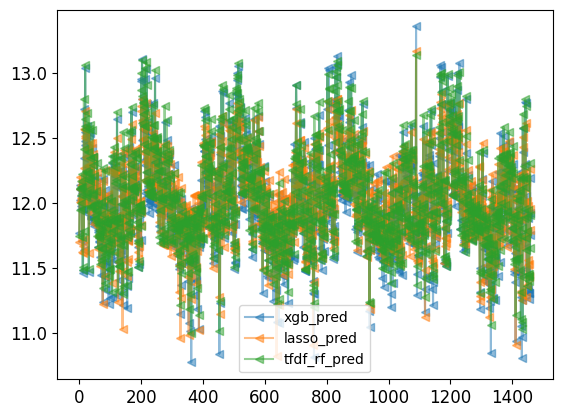

In [81]:
xgb_pred=xgb_model.predict(X_test_imp)
lasso_pred=lasso_model.predict(X_test_imp)
preds=pd.DataFrame({'xgb_pred':xgb_pred,
                    'lasso_pred':lasso_pred,
                    'tfdf_rf_pred':tfdf_rf_pred.reshape(1,-1)[0]})
preds.plot(marker="<",alpha=0.5)
print(f"rmse for xgb predict vs lasso predict {rmse(xgb_pred,lasso_pred)}")
print(f"rmse for xgb predict vs tfdf_rf predict {rmse(xgb_pred,tfdf_rf_pred)}")
print(f"rmse for lasso predict vs tfdf_rf predict {rmse(lasso_pred,tfdf_rf_pred)}")

**[Note]**: no tuning parameter in this project. One can tune paramenter via GridSearchCV

In [82]:
pred=0.7*xgb_pred+0.2*lasso_pred+0.1*tfdf_rf_pred.reshape(1,-1)[0]

In [83]:

output = pd.DataFrame({'Id': ids_test,
                       'SalePrice': np.expm1(pred.squeeze()) })
output.head()

Id      SalePrice
0  1461  126747.125809
1  1462  164219.241669
2  1463  180341.234979
3  1464  188572.366165
4  1465  182243.992101

In [84]:
output.to_csv('/kaggle/working/submission.csv', index = False)